In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score
)

from utils import get_data

# sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
X, y, metadata, variables = get_data('dry_bean_dataset')

In [3]:
y.value_counts(normalize=True)

Class   
DERMASON    0.260525
SIRA        0.193667
SEKER       0.148924
HOROZ       0.141650
CALI        0.119756
BARBUNYA    0.097127
BOMBAY      0.038351
Name: proportion, dtype: float64

In [4]:
# Split data into train and test sets.
# We use Stratifield sampling to ensure that the distribution of the data is maintained across the sample.
# Use stratified kfold cross validation to ensure that the model is not overfitting the data

TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [5]:
idx = variables['type'].isin(['Integer', 'Continuous'])
num_cols = variables.loc[idx, 'name']
num_cols = num_cols.loc[~num_cols.isin(y.columns.tolist())]
num_cols

0                Area
1           Perimeter
2     MajorAxisLength
3     MinorAxisLength
4         AspectRatio
5        Eccentricity
6          ConvexArea
7       EquivDiameter
8              Extent
9            Solidity
10          Roundness
11        Compactness
12       ShapeFactor1
13       ShapeFactor2
14       ShapeFactor3
15       ShapeFactor4
Name: name, dtype: object

In [6]:
idx = variables['type'].isin(['Binary', 'Categorical'])
cat_cols = variables.loc[idx, 'name']
cat_cols = cat_cols.loc[~cat_cols.isin(y.columns)]
cat_cols

Series([], Name: name, dtype: object)

# Train the Expectation Maximisation

In [8]:
RANDOM_STATE = 42
N_JOBS = -1
VERBOSE = 4

# For KMeans use the default algo, max_iterations, init='k-means++'
# clus = GaussianMixture(n_init=100, init_params='k-means++', random_state=RANDOM_STATE, covariance_type='full')
scaler = StandardScaler()
clus = GaussianMixture(random_state=RANDOM_STATE)
clus_pipeline = Pipeline(steps=[
    ('scaler', scaler),
    ('model', clus)
])


In [9]:
clus_pipeline.set_params(model__n_components=3)
clus_pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GaussianMixture(n_components=3, random_state=42))])

In [12]:
results = {}
for n_components in range(2, 20):
    print(f"---------- n_components: {n_components} ----------")
    clus_pipeline.set_params(model__n_components=n_components)
    clus_pipeline.fit(X_train)
    
    # clus_labels = clus_pipeline.named_steps['model'].labels_
    # sil_score = silhouette_score(X_train, clus_labels)
    
    results[n_components] = {'aic': clus_pipeline.named_steps['model'].aic(X_train.values),
                             'bic': clus_pipeline.named_steps['model'].bic(X_train.values),
                             # 'sil_score': sil_score
                           }

---------- n_components: 2 ----------
---------- n_components: 3 ----------
---------- n_components: 4 ----------
---------- n_components: 5 ----------
---------- n_components: 6 ----------
---------- n_components: 7 ----------
---------- n_components: 8 ----------
---------- n_components: 9 ----------
---------- n_components: 10 ----------
---------- n_components: 11 ----------
---------- n_components: 12 ----------
---------- n_components: 13 ----------
---------- n_components: 14 ----------
---------- n_components: 15 ----------
---------- n_components: 16 ----------
---------- n_components: 17 ----------
---------- n_components: 18 ----------
---------- n_components: 19 ----------


In [86]:
print(results)

{2: {'aic': 6.135332222142268e+16, 'bic': 6.1353322221424904e+16}, 3: {'aic': 2.013495039561106e+18, 'bic': 2.0134950395611092e+18}, 4: {'aic': 2.46679272681232e+18, 'bic': 2.4667927268123244e+18}, 5: {'aic': 2.4667927268123203e+18, 'bic': 2.466792726812326e+18}, 6: {'aic': 2.3882858467141046e+17, 'bic': 2.3882858467141715e+17}, 7: {'aic': 3.190076688123718e+17, 'bic': 3.190076688123796e+17}, 8: {'aic': 3.0271268174962586e+17, 'bic': 3.027126817496348e+17}, 9: {'aic': 2.6028489862565184e+17, 'bic': 2.602848986256619e+17}, 10: {'aic': 2.466792726812322e+18, 'bic': 2.466792726812333e+18}, 11: {'aic': 2.3717855220866358e+17, 'bic': 2.3717855220867587e+17}, 12: {'aic': 2.4667927268123223e+18, 'bic': 2.4667927268123356e+18}, 13: {'aic': 2.5207391864039408e+17, 'bic': 2.5207391864040858e+17}, 14: {'aic': 3.980352788380548e+18, 'bic': 3.980352788380564e+18}, 15: {'aic': 2.8280805235859666e+18, 'bic': 2.8280805235859835e+18}, 16: {'aic': 2.8712964372138957e+18, 'bic': 2.871296437213913e+18}, 1

<Axes: title={'center': 'BIC'}, xlabel='n_components'>

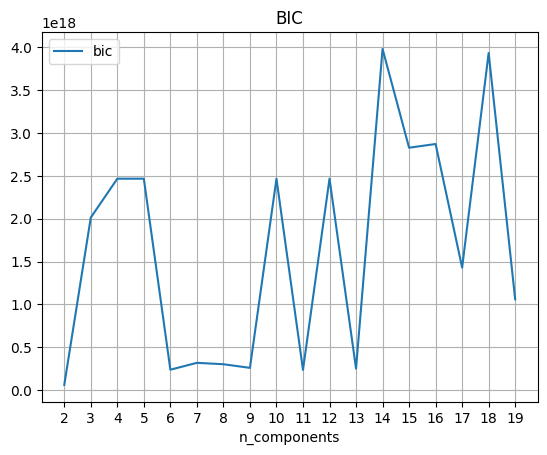

In [87]:
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
results_df.columns = ['n_components', 'aic', 'bic']
results_df.plot(x='n_components', y='bic',title='BIC', xticks=results_df['n_components'], grid=True)